<a href="https://colab.research.google.com/github/DHI-GRAS/CTCN-workshop-2023/blob/main/notebooks/module_4_coasts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coastal analysis with tidal context

This module builds upon the previous ones, but with a specific focus on the coastal zone. Many of the same methods can be applied, but it's important to consider the role that tides may play in our analysis and try to mitigate their impact.  It corresponds to the methodology outlined in section 4.3 of the training manual with step-by-step instruction in section 5.4. 

**Upon completion of this notebook, you will be able to:**

1.   Add tide data to a Sentinel-2 collection.
2.   Create high and low tide collections and composites.
3.   Identify areas sensitive to tides (e.g. intertidal zones).
4.   Compute trends across time.
5.   Visualize and export results.

The below image represents the processing pipeline for this module. It provides a good overview of how we will process data in this notebook. Do not worry, we will explain each step further down!



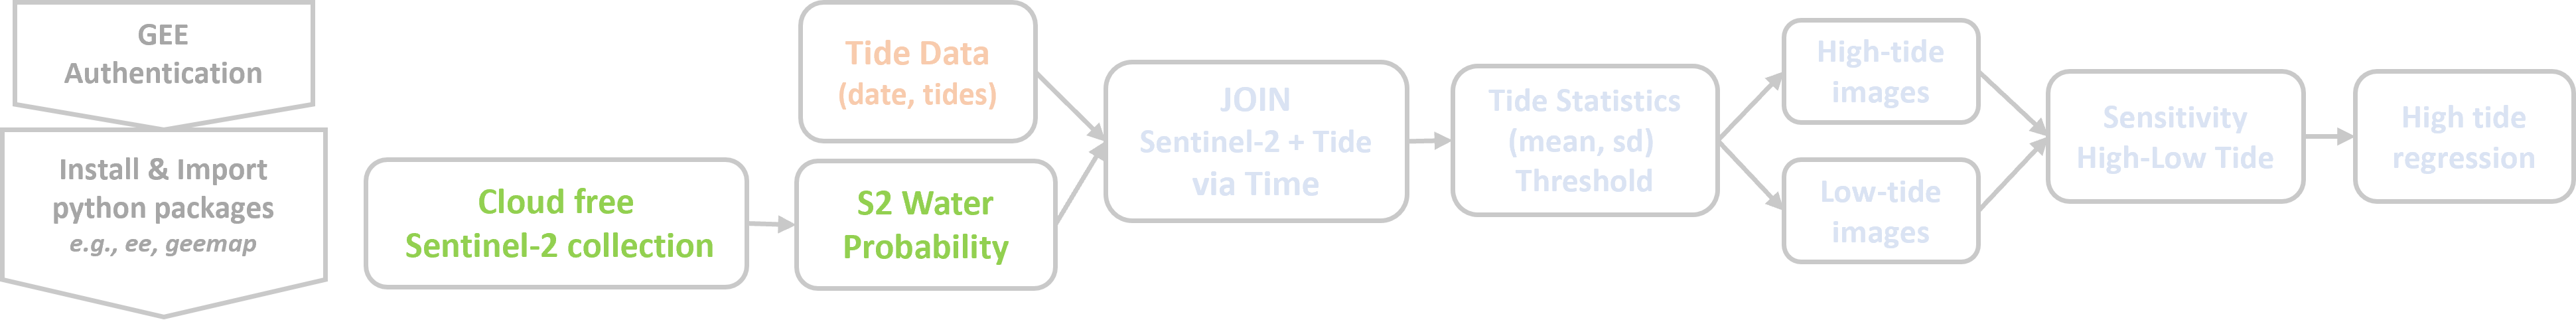

First, we are going to set up our working environment by installing and importing any dependencies for our analysis. This includes the core GEE API, as well as some additional libraries that help us interact with the data in a Python environment. 



In [51]:
# Install the earthengine-api.
!pip install -q earthengine-api

# Import the Earth Engine library.
import ee

# Trigger the authentication flow.
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=sA0nVGkpl6eoFNmoy3TFINkwFboVKnLqBopLKF3bL4Y&tc=0b7VvWzQtr7E4Swa3Gmx3SUieLBWXkub454w2uJQIkQ&cc=l1zPKlF_zqoLLeNGDMsxEK1u-MS8kfg1h_BNlsACGfI

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AbUR2VOVh7Q8M5Ggs74milDWLq5ETEkoxHcySE3q6tC9T5AGACh5TSFf8Y4

Successfully saved authorization token.


Install and import the python libraries. Geemap is the python package for interactive mapping with Google Earth Engine (GEE).

In [52]:
# Install geemap library.
%%capture
!pip install geemap

In [53]:
# Import the geemap library.
import geemap


# 1) Load and explore tide data



Please note that estimating tides (or water levels) in coastal environments is complex. Therefore, estimations accuracies may vary due to a number of factors.


We will start by loading tide the tide data, i.e., *tides_2022_11_22.csv* provided on GitHub. 

In [54]:
import pandas as pd

## copy and paste raw url from github repo.
url = r'https://raw.githubusercontent.com/DHI-GRAS/CTCN-workshop-2023/main/data/tides_2022_11_22.csv'
df = pd.read_csv(url, names=['date', 'tides'])
print(df.head(5))

         date     tides
0  11/22/2012  0.188058
1  11/23/2012  0.499850
2  11/24/2012  0.668436
3  11/25/2012  0.689802
4  11/26/2012  0.587833


Explore the tide data that's been pre-created.

 We'll add the lon lat coordinates to the dataframe. We can use this geometry later.

In [55]:
## add the lon lat coordinates to the dataframe
from datetime import datetime 
df['lon'] = 91
df['lat'] = 22
df["date"] = df["date"].astype('datetime64[ns]').astype(str)
df

date     tides  lon  lat
0     2012-11-22  0.188058   91   22
1     2012-11-23  0.499850   91   22
2     2012-11-24  0.668436   91   22
3     2012-11-25  0.689802   91   22
4     2012-11-26  0.587833   91   22
...          ...       ...  ...  ...
3649  2022-11-19  0.597187   91   22
3650  2022-11-20  0.784154   91   22
3651  2022-11-21  0.846214   91   22
3652  2022-11-22  0.745477   91   22
3653  2022-11-23  0.475521   91   22

[3654 rows x 4 columns]

The geemap library has some nice functions that enable us to convert our pandas dataframe into an earth engine object.

In [56]:
!pip install geojson

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [57]:
## convert to an earth engine object.
from geemap.common import df_to_ee

gee_df = df_to_ee(df, latitude='lat', longitude='lon')
gee_df

Let's visualise the location from where the tide levels have been estimated.

In [58]:
# Visualize the point
first_point = ee.Feature(gee_df.first())

# Add the AOI to the Map.
Map = geemap.Map(center=[22, 91], zoom=7, height=400, draw = True)
Map.add_basemap("SATELLITE")
Map.addLayer(first_point, {'color':'red'}, "Tide point")
Map

Map(center=[22, 91], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Tog…

We can also compute some statistics about the tides. 

*Q: Explore the object below, what are the estimated maximum and minimum tides experienced?*

In [59]:
# This is some statistics of all the tide values in our CSV we uploaded.
gee_df.aggregate_stats('tides')

We can see the maximum tide is +1.16m and the minimum is -1.46m.

# 2) Create Sentinel-2 collection


Now we're going to create a Sentinel-2 collection in our area of interest, to use in combination with the tide data. The functions below are reused from the previous modules. We'll apply a cloud mask and add a water probability band to the images.

In [60]:
# This function returns a masked sentinel-2 collection.
def get_cloud_masked_s2(start_date, end_date, AOI, cloud_threshold):
  # Get the sentinel-2 collection, filter by date and geometry.
  s2 = ee.ImageCollection("COPERNICUS/S2_HARMONIZED").filter([
           ee.Filter.date(start_date, end_date),
           ee.Filter.bounds(AOI)])
  
  # Get the cloudless collection.
  s2_cloudless = ee.ImageCollection("COPERNICUS/S2_CLOUD_PROBABILITY").filter([
            ee.Filter.date(start_date, end_date),
            ee.Filter.bounds(AOI)])

  # join the two collections together.
  join = ee.Join.inner().apply(**{
        'primary': s2,
        'secondary': s2_cloudless,
        'condition': ee.Filter.equals(**{'leftField': 'system:index','rightField': 'system:index'})})
  
  ## reformat it back to an image collection.
  merged = ee.ImageCollection(
      join.map(lambda feature: ee.Image(feature.get('primary')).addBands(feature.get('secondary'))))

  # apply the cloud masking.
  cloud_masked = merged.map(
    lambda image: image.updateMask(image.select('probability').lt(cloud_threshold))) 

  # Return a cloud masked image.
  return cloud_masked
     
def add_s2_water_probability (image):
  # Create the required input bands.
  ndvi = image.normalizedDifference(['B8','B4']).rename('ndvi')
  ndwi = image.normalizedDifference(['B3','B8']).rename('ndwi')

  # Add them and compute the water probability.
  water_probability = image.addBands([ndvi, ndwi]).expression(
      "1 / (1 + exp(- (0.845 + (2.14 * b('ndvi')) + (13.5 * b('ndwi')))))"
      ).multiply(100).rename(['water_probability'])

  # Return the original image + the water probability.
  return image.addBands([water_probability, ndvi, ndwi])


We have created the required functions, now let's input the parameters and get the imagery. 

In [84]:
# We'll use imagery within 100km of our tide point.
geometry = first_point.buffer(70000).geometry()

s2_collection = (get_cloud_masked_s2(
    start_date = '2016-01-01', 
    end_date = '2023-01-01', 
    AOI = geometry, ##intersects with our point 
    cloud_threshold = 40
    ).map(add_s2_water_probability)
)

# Create a median image for visualisation and clip to geometry.
s2_median = s2_collection.median().clip(geometry)

We can visualise the median composite to check we've got the data we wanted. We'll also visualise the tide point location.

In [85]:
# Add the AOI to the Map.
Map = geemap.Map(center=[22, 91], zoom=8, height=500, draw = True)
Map.add_basemap("TERRAIN")
Map.addLayer(s2_median, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 2500},'s2 RGB median')
Map.addLayer(first_point, {'color':'red'}, "Tide point")
Map

Map(center=[22, 91], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Tog…

# 3) Create high and low tide Sentinel-2 collections

So far, we have accessed our tide data, and reformatted it so that is its compatible with GEE. We have also got a pre-processed Sentinel-2 collection in our area of interest. 

Now we are going to merge the two datasets by adding the tide properties to the corresponding Sentinel-2 images. Once we have done that, we can use those properties to filter the images into high or low tide collections and work with those. 

Hopefully this mitigates the impact of tides on our analysis! 

In [86]:
# First add a time property in the same format as our tide data: YYYY-MM-dd'
s2_collection = s2_collection.map(
    lambda image: image.set('time', image.date().format('YYYY-MM-dd'))
    )

# Lots of info... bands, id, and at the bottom is our new attribute.
s2_collection.first()

In [87]:
# Join the imagery to the tides by time property.
time_filter = ee.Filter.equals(leftField= 'time', rightField= 'date')
inner_join = ee.Join.inner()

# The join returns a feature collection with primary being s2 image, and secondary being date.
joined = inner_join.apply(s2_collection, gee_df, time_filter)

# Let's reformat that back to an image collection with the tides as attribute.
def tides_as_attribute (joined):
  image = ee.Image(joined.get('primary'))
  tide = ee.Feature(joined.get('secondary')).get('tides')
  return image.set('tide', tide)

# Apply the function.
tide_collection = ee.ImageCollection(joined.map(tides_as_attribute))

tide_collection.size().getInfo()

4604

We can see that tide has been added as an attribute to the image.

In [88]:
tide_collection.first()

We explored the statistics of our tide data earlier. However, many of the observations may not have a coincident Sentinel-2 image. Let's recalculate those statistics with tide values where we actually have imagery available.

In [89]:
tide_collection.aggregate_stats('tide')

We'll define high and low tide as anything above, or below, 1 standard deviation from the mean. We can calculate that from the statistics we just calculated.

In [90]:
# +/- 1 standard deviation
stats = tide_collection.aggregate_stats('tide') 
mean = stats.getNumber('mean')
sd = stats.getNumber('total_sd')

print(
 f" mean ({mean.format('%.2f').getInfo()}) +/- 1 standard deviation \
 ({sd.format('%.2f').getInfo()}) = \
 {mean.subtract(sd).format('%.2f').getInfo()} to \
 {mean.add(sd).format('%.2f').getInfo()}"
)

 mean (-0.14) +/- 1 standard deviation  (0.69) =  -0.83 to  0.55


Using those statistics, we'll define the thresholds to separate our collection by tides. Feel free to modify these values if you like.

In [91]:
high_tide_threshold = 0.55
low_tide_threshold = -0.83

Apply a filter using those thresholds, and count how many images are in each collection.

In [92]:
high_tide_collection = tide_collection.filter(ee.Filter.gt('tide', high_tide_threshold))
low_tide_collection = tide_collection.filter(ee.Filter.lt('tide', low_tide_threshold))

high_tide_size = high_tide_collection.size().getInfo()
low_tide_size = low_tide_collection.size().getInfo()

print(f'\
Number of images in the high tide collection {high_tide_size} \n\
Number of images in the low tide collection {low_tide_size}'
)

Number of images in the high tide collection 1068 
Number of images in the low tide collection 1029


Let's visualise them as a S2 median image and see how they look.

In [93]:
# Get filtered medians.
high_tide_median = high_tide_collection.median().clip(geometry)
low_tide_median = low_tide_collection.median().clip(geometry)

# Visualisation palette taken from https://colorbrewer2.org/
BrGr_palette = ['#543005','#8c510a','#bf812d','#dfc27d','#f6e8c3','#f5f5f5',
                '#c7eae5','#80cdc1','#35978f','#01665e','#003c30']

# Add the AOI to the Map.
Map = geemap.Map(center=[22.5, 91], zoom=11, height=650, draw = True)
Map.add_basemap("TERRAIN")
left_layer = geemap.ee_tile_layer(high_tide_median, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 2000}, 'High tide median')
right_layer = geemap.ee_tile_layer(low_tide_median, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 2000}, 'Low tide median')
Map.split_map(left_layer, right_layer)
Map

Map(center=[22.5, 91], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

Let's visualise them as water probability median image and see how they look.

In [94]:
BrGr_palette = ['#AD8854','#DFB645','#FEFCFA','#0B9ED2','#053355']
vis_params = {'bands': ['water_probability'], 'min': 0, 'max': 100, 'palette':BrGr_palette}

Map = geemap.Map(center=[22.5, 91.1], zoom=11, height=650, draw = True)
Map.add_basemap("TERRAIN")
left_layer = geemap.ee_tile_layer(high_tide_median, {'bands': ['water_probability'], 'min': 0, 'max': 100, 'palette': BrGr_palette}, 'High tide-water probability')
right_layer = geemap.ee_tile_layer(low_tide_median, {'bands': ['water_probability'], 'min': 0, 'max': 100, 'palette': BrGr_palette}, 'Low tide-water probability')
Map.split_map(left_layer, right_layer)
Map.add_colorbar(vis_params, label="Water probability[%]", layer_name="Water probability")
Map

Map(center=[22.5, 91.1], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out…


*Q: Can we see the differences in the tides?*

The tide data is not perfect, tides are complex and impacted by a number of phenomena.

*Q: What could this be useful for? mud banks at low tide?*

Remember you can also "turn on" the water probability layers too!

We can export those images if you like. The file sizes are quite large ~2GB, so consider if it's necessary. The default export parameters will export a 4-band image that includes the red, green and blue channels. In addition, we add the median water_probability values. 


In [95]:
# Export them.

task = ee.batch.Export.image.toDrive(
            image = high_tide_median.select(['B4', 'B3', 'B2', 'water_probability']).uint16(),
            description = 'High-tide-image',
            folder = 'CTCN-workshop',
            region = geometry,
            scale = 10,
            maxPixels = 10e12,
            formatOptions = {'cloudOptimized': True}
            )

task.start()


In [96]:
task = ee.batch.Export.image.toDrive(
            image = low_tide_median.select(['B4', 'B3', 'B2', 'water_probability']).uint16(),
            description = 'Low-tide-image',
            folder = 'CTCN-workshop',
            region = geometry,
            scale = 10,
            maxPixels = 10e12,
            formatOptions = {'cloudOptimized': True}
            )

task.start()


>**TIP**: Check the code editor: https://code.earthengine.google.com/tasks to see the status of your export or run task.status() command, which a dictionary containing information such as the state of the task and its ID.

# 4) Look for tide sensitivities

We could also look at the difference between the high and low tide images to try to understand which areas are sensitive to tides. 

In the coastal areas this may identify exposed mudflats, but you may also see changes due to water quality and some "in-land" changes due to inundation. The inland areas may be less suitable for development (infrastructure, agriculture etc.) if they are at risk from high tides. 

*Q: What else could this analysis be useful for?*

In [97]:
# Compute the difference.
difference_image = high_tide_median.subtract(low_tide_median).select('water_probability')

# Create a mask that identifies the larger changes.
difference_mask = difference_image.gt(10).Or(difference_image.lt(-10))

In [98]:
# Visualise it.
vis_params = {'bands': ['water_probability'], 'min': -25, 'max': 25, 'palette':BrGr_palette}


Map = geemap.Map(center=[22, 91], zoom=11, height=600, draw = True)
Map.add_basemap("TERRAIN")
Map.addLayer(high_tide_median, {'bands': ['B4', 'B3', 'B2'], 'min': 500, 'max': 2000}, 'High Tide Median')
Map.addLayer(low_tide_median, {'bands': ['B4', 'B3', 'B2'], 'min': 500, 'max': 2000}, 'Low Tide Median')
Map.addLayer(difference_image, {'min': -25, 'max': 25}, 'difference water probability', False)
Map.addLayer(difference_image.updateMask(difference_mask), {'min': -25, 'max': 25, 'palette': BrGr_palette}, 'Difference water probability MASKED')
Map.add_colorbar(vis_params, label="Difference Water Probability", layer_name="Difference water probability")
Map

Map(center=[22, 91], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Tog…

We can export this images if you like. The file size is quite small ~33MB.

In [99]:
# Export the mask.

task = ee.batch.Export.image.toDrive(
            image = difference_image.updateMask(difference_mask).int8(),
            description = 'Tide-difference-image',
            folder = 'CTCN-workshop',
            region = geometry,
            scale = 10,
            maxPixels = 10e12,
            formatOptions = {'cloudOptimized': True})

task.start()

>**TIP**: Check the code editor: https://code.earthengine.google.com/tasks to see the status of your export or run task.status() command, which a dictionary containing information such as the state of the task and its ID.

# 5) High/ low tide vectors

This data could be useful as a vector layer that delineates the "high" or "low" tide. We can use the water_probability band we created and apply a threshold to classify into land or water. Then we just need to convert the binary raster to a vector.

In [100]:
# Use the water probability to make land/water mask. 
land_water_threshold = 70

high_tide_mask = high_tide_median.select('water_probability').lt(land_water_threshold)
high_tide_vector = high_tide_mask.selfMask().reduceToVectors(
    **{'geometry': geometry, 
       'scale': 10, 
       'eightConnected': True, 
       'labelProperty': 'label', 
       'bestEffort': True, 
       'maxPixels': 10e12}
        )


low_tide_mask = low_tide_median.select('water_probability').lt(land_water_threshold)
low_tide_vector = low_tide_mask.selfMask().reduceToVectors(
    **{'geometry': geometry, 
       'scale': 10, 
       'eightConnected': True, 
       'labelProperty': 'label', 
       'bestEffort': True, 
       'maxPixels': 10e12}
        )

We can export those vector data. The file sizes are quite small ~82MB and it takes 8min to process.

In [101]:
# Export the land vectors for each tide as a GEOJSON.

task = ee.batch.Export.table.toDrive(
            collection = high_tide_vector,
            description = 'High-tide-land',
            folder = 'CTCN-workshop',
            fileFormat = 'GEOJSON'
            )

task.start()

task = ee.batch.Export.table.toDrive(
            collection = low_tide_vector,
            description = 'Low-tide-land',
            folder = 'CTCN-workshop',
            fileFormat = 'GEOJSON'
            )

task.start()



>**TIP**: Check the code editor: https://code.earthengine.google.com/tasks to see the status of your export or run task.status() command, which a dictionary containing information such as the state of the task and its ID.

# 6) High tide regression

Finally, let's look at linear regression again. We'll focus on the high tide collection, but you could easily replace that with the low-tide collection if that's of interest to you.

When we compute linear regression, we are looking for trends across the entire time-series. Let's see if that gives us an indication of areas that might be changing independently of tidal variations.

In [102]:
high_tide_collection

Here we'll compute linear regression and also a mask that retains only the areas that have a trend that is either greater than or less than 1.

In [103]:

def add_time_band (image):
  basedate = ee.Date.fromYMD(2016, 1, 1) # days from 2016-01-01
  image_date = image.date()

  ## difference between the dates, with units month.
  time_difference = ee.Image(image_date.difference(basedate, 'month')).rename('time')

  ## add the band
  return image.addBands(time_difference).float()


## Add the time band
high_tide_regression = high_tide_collection.map(add_time_band)
high_tide_linear_fit = high_tide_regression.select(
    ['time', 'water_probability']
    ).reduce(
        ee.Reducer.linearFit()
        ).clip(geometry)


## We'll just visualise the areas where we see changes greater or less than 1.
high_tide_change_mask = high_tide_linear_fit.select('scale').gt(1).Or(
    high_tide_linear_fit.select('scale').lt(-1))


In [ ]:
high_tide_linear_fit

Visualise the results:

- blue is increasing trend --> getting wetter / possible erosion.

- red is decreasing trend --> getting drier / possible accretion.

*Q: Can you find any interesting areas of change?*

You can access the coordinates using the inspector tool.

In [ ]:
red_blue = ['#ca0020','#f4a582','#f7f7f7','#92c5de','#0571b0']

Map = geemap.Map(center=[22.3, 91], zoom=10, height=500, draw = True)
Map.add_basemap("SATELLITE")
Map.addLayer(high_tide_median, {'bands': ['B4', 'B3', 'B2'], 'min': 500, 'max': 2000}, 'high_tide_median')
Map.addLayer(low_tide_median, {'bands': ['B4', 'B3', 'B2'], 'min': 500, 'max': 2000}, 'low_tide_median')
Map.addLayer(high_tide_linear_fit.updateMask(high_tide_change_mask), {'bands': ['offset'], 'min': 0, 'max': 100, 'palette': red_blue},'Linear Reg. (offset)', False)
Map.addLayer(high_tide_linear_fit.updateMask(high_tide_change_mask), {'bands': ['scale'], 'min': -3, 'max': 3, 'palette': red_blue},'Linear Reg. (scale)')
Map


In [ ]:
# Export the results.

task = ee.batch.Export.image.toDrive(
            image = high_tide_linear_fit.updateMask(high_tide_change_mask).int8(),
            description = 'high-tide-regression-image',
            folder = 'CTCN-workshop',
            region = geometry,
            scale = 10,
            maxPixels = 10e12,
            formatOptions = {'cloudOptimized': True}
            )

task.start()

>**TIP**: Check the code editor: https://code.earthengine.google.com/tasks to see the status of your export or run task.status() command, which a dictionary containing information such as the state of the task and its ID.

We focussed on the high tide collection but you could try changing the collection to the low tide imagery if you want. You could also try vectorizing the data and exporting that - if it's more useful to you in that format. 